# Chapter 10 Questions

1. The graph is two starting neurons $A$ and $B$ that are each connected to intermediate neurons $X$ and $Y$.
There are two edges from $A$ to $X$ and one negated edge from $B$ to $X$, representing the $AND$ operation with a negated input on $B$.
Then to $Y$ there are two edges from $B$ and one negated edged from $A$.  Finally, all four edges from $X$ and $Y$ to output node $Z$ which represents the $OR$ operation.

2. Logistic regression is preferred to classical perceptron because the sigmoid layer outputs class probabilities and training a logistic model will always yield some type of final solution if the data is linearly separaable.  A perceptron only converges if the classes are linearly separable and does not output class probabilities.  However, using a logistic function for the output layer and training with gradient descent makes the two models equivalent.

3. The logisitc function was crucial to training MLPs because it is everywhere differentiable so gradient descent can be used.

4. Popular activations: ReLu, sigmoid, softmax and leaky ReLu.

5. _Consider the MLP with an input layer of 10 passthrough neurons, a hidden layer of 50 neurons and an output layer of 3 neurons. All activations are ReLu._
The input matrix has shape $n \times 10$, the hiden layer weight matrix has shape $10 \times 50$ and the output layer has shape $50 \times 3$.
The overall equation is $Y = ReLu(ReLu(X W_h + b)W_o + b_o)$

6. Final layers:
_spam/ham_: one neuron, logistic activation
_MNIST_: ten neurons, softmax activation
_regression_: one neuron, identity activation

7. Backpropagation: is a gradient descent method to train neural networks.  Batches of data are used to estimate the gradient and update model parameters to move closer to a minima of the loss function.  Backprop is the full process and reverse-mode autodiff is single process of one pass through the network to compute ever noe's value for the current batch, followed by a reverse pass to compute all of the gradients at once.

8. Hyperparamters that can be tweaked for training: number of hidden layers; number of neurons per hidden layer; type of activation functions. 
if model is overfitting then can reduce any of the first two above.

## Question 9. 
Train a deep MLP on MNIST and try to get over $98\%$ prediction precision.  Plot learning curves and try to save model checkpoints.

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torcheval.metrics.functional import multiclass_confusion_matrix
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
print(type(training_data))
training_frac = 0.85
training_size = int(training_frac*len(training_data))
valid_size = len(training_data) - training_size
train_split, valid_split = random_split(training_data,[training_size, valid_size])

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

<class 'torchvision.datasets.mnist.MNIST'>


In [53]:
#X_train, y_train = training_data.data, training_data.targets
train_loader = DataLoader(train_split, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_split, batch_size=32, shuffle=True)

# X_test, y_test = test_data.data, test_data.targets
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

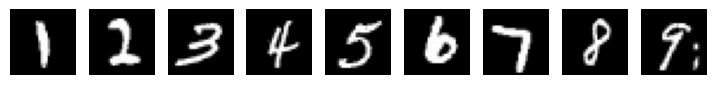

In [54]:
figure = plt.figure(figsize=(10, 1))
labels_seen = {}
for batch_idx, (data, target) in enumerate(train_loader):
    for i, lab_i in enumerate(target):
        target_class = lab_i.item()
        if target_class in labels_seen:
            continue
        labels_seen[target_class] = i
    for class_label, idx in labels_seen.items():
        plt.subplot(1, 10, class_label + 1)
        plt.imshow(data[idx][0], cmap='gray')
        plt.axis('off')
    break

In [56]:
class BasicMLP(torch.nn.Module):
    def __init__(self, num_outputs:int|np.int64):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(28*28, num_outputs),
            torch.nn.ReLU(),
            torch.nn.Linear(num_outputs, 10)
        )
    def forward(self, x:torch.Tensor):
        return self.layers(x)
    
baseline_model = BasicMLP(20)
print(type(baseline_model))
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(baseline_model.parameters(), lr=0.01, momentum=0.9)
print(baseline_model)
print(baseline_model.load_state_dict)

<class '__main__.BasicMLP'>
BasicMLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=20, bias=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=10, bias=True)
  )
)
<bound method Module.load_state_dict of BasicMLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=20, bias=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=10, bias=True)
  )
)>


We define an evaluator class to avoid repeated code when comparing the models.

In [57]:
class ModelEvaluator:
    def __init__(self, training_data:DataLoader, validation_data:DataLoader, model: torch.nn.Module,
                loss_fn:torch.nn.modules.loss, optimizer:torch.optim, num_epochs:int, model_str_prefix:str):
        """
        The model should be defined with the necessary hyperparameters prior to calling this function.
        """
        self.train_loader = training_data
        self.valid_loader = validation_data
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.model_str_prefix = model_str_prefix + "_"
        
        


        # class members that we calculate
        self.training_losses = torch.empty((self.num_epochs, ), dtype=torch.float)
        self.validation_losses = torch.empty((self.num_epochs, ), dtype=torch.float)
        self.test_predictions = None

    def train(self, save_model_checkpoints:bool=False) -> None:

        print("-"*80)
        print(f"{'Epoch':>10}{'Train Frac. Correct':>20}{'Train Loss':>15}{'Valid Loss':>15}")
        print("-"*80)

        for epoch in range(self.num_epochs):
            epoch_loss = 0
            epoch_num_correct = 0
            for batch in self.train_loader:
                images, labels = batch 
                self.optimizer.zero_grad()
                output = self.model(images)
                loss_eval = self.loss_fn(output, labels)
                loss_eval.backward()
                self.optimizer.step()
                epoch_loss += loss_eval.item()
                epoch_num_correct += self.get_num_correct(output, labels)
            
            # diagnostics
            self.training_losses[epoch] = epoch_loss / len(train_loader.dataset)
            self.validate(epoch)
            res_str = f"{epoch+1:>10}{(epoch_num_correct/len(train_loader.dataset)):>20.5f}{self.training_losses[epoch]:>15.8f}{self.validation_losses[epoch]:>15.8f}"
            print(res_str)
            if save_model_checkpoints:
                torch.save(self.model.state_dict(),  "model_checkpoints/chapter10/" + self.model_str_prefix + "checkpoint_epoch_" + str(epoch) + ".pt")
        fraction_correct = 100. * epoch_num_correct / len(train_loader.dataset)
        print("-"*80)
        print(f"{'Fraction correct:':<15}{fraction_correct:>15.5f}%")
        print("-"*80)

    def plot_losses(self, log_y_axis:bool=False) -> None:
        fig, ax = plt.subplots()
        ax.plot(np.arange(self.num_epochs), self.training_losses, label='Training loss')
        ax.plot(np.arange(self.num_epochs), self.validation_losses, label='Validation loss')
        ax.legend()
        ax.set_xlabel('Epoch')
        ax.set_ylabel("Normalized loss")
        if log_y_axis:
            ax.set_yscale('log')
        ax.grid()
        plt.show()

    def validate(self, epoch_idx:int) -> None:
        self.model.eval()
        with torch.no_grad():
            valid_loss = 0.
            valid_num_correct = 0
            for batch in self.valid_loader:
                images, labels = batch
                output = self.model(images)
                valid_loss += self.loss_fn(output, labels).item()
                valid_num_correct += self.get_num_correct(output, labels)
        #fraction_correct = 100. * valid_num_correct / len(valid_loader.dataset)
        self.validation_losses[epoch_idx] = valid_loss / len(valid_loader.dataset)
        # to do: add other metrics in here like confusion matrix?

    def select_best_model(self, model_class:torch.nn.Module, model_params: dict) -> torch.nn.Module:
        """
        The goal in this task is to find a model with over 98% precision.
        We iterate through all of the saved models and select the one with the highest precision.
        """
        best_precision = -np.inf
        best_model = None

        for epoch in range(self.num_epochs):
            path = "model_checkpoints/chapter10/" + self.model_str_prefix + "checkpoint_epoch_" + str(epoch) + ".pt"
            #checkpoint_model = BasicMLP(num_outputs)
            checkpoint_model = model_class(**model_params)
            checkpoint_model.load_state_dict(torch.load(path))
            checkpoint_model.eval()
            with torch.no_grad():
                all_predictions = []
                all_targets = []
                for batch in self.valid_loader:
                    images, labels = batch
                    pred_mat = checkpoint_model(images)
                    all_predictions.extend(pred_mat.argmax(1).cpu().numpy())
                    all_targets.extend(labels.cpu().numpy())
                cm = confusion_matrix(all_targets, all_predictions)
                precision_per_class = cm.diagonal() / cm.sum(axis=0)
                print(f"Epoch: {epoch+1}, Min Precision: {np.min(precision_per_class):.4f}, Median Precision: {np.median(precision_per_class):.4f}, Max Precision: {np.max(precision_per_class):.4f}")
                print("-"*80)
                if np.min(precision_per_class) > best_precision:
                    best_precision = np.min(precision_per_class)
                    best_model = checkpoint_model
                    best_epoch = epoch 
            print("-"*80)
        print(f"Best model is from epoch {best_epoch} with Min Precision: {best_precision:.4f}")
        return best_model

    def test_model(self, test_loader:DataLoader, test_model:torch.nn.Module=None) -> None:
        test_loss = 0.
        test_num_correct = 0
        all_predictions = []
        all_targets = []
        this_model = self.model if test_model is None else test_model
        
    
        this_model.eval()
        with torch.no_grad():
            for batch in test_loader:
                images, labels = batch
                pred_mat = this_model(images) #self.model(images)
                test_loss += self.loss_fn(pred_mat, labels).item()
                preds = pred_mat.argmax(1).cpu().numpy()
                test_num_correct += self.get_num_correct(pred_mat, labels)
                all_predictions.extend(preds)
                all_targets.extend(labels.cpu().numpy())
            cm = confusion_matrix(all_targets, all_predictions)
            precision_per_class = cm.diagonal() / cm.sum(axis=0)
        fraction_correct = 100. * test_num_correct / len(test_loader.dataset)
        average_test_loss = test_loss / len(test_loader.dataset)
        min_precision_class = np.argmin(precision_per_class)
        median_precision_class = np.argsort(precision_per_class)[len(precision_per_class) // 2]
        max_precision_class = np.argmax(precision_per_class)
        print(f"{'Test accuracy:':<25}{fraction_correct:>15.5f}%")
        print(f"{'Test loss:':<25}{average_test_loss:>15.5f}%")
        print(f"{'Min Precision:':<25}{np.min(precision_per_class):>15.4f} (Class: {min_precision_class})")
        print(f"{'Median Precision:':<25}{np.median(precision_per_class):>15.4f} (Class: {median_precision_class})")
        print(f"{'Max Precision:':<25}{np.max(precision_per_class):>15.4f} (Class: {max_precision_class})")

    def get_num_correct(self, model_outputs:torch.Tensor, labels:torch.Tensor):
        assert len(model_outputs) == len(labels)
        preds = model_outputs.squeeze().argmax(dim=1)
        return preds.eq(labels).sum().item()
    
    def get_example_prediction(self, model:torch.nn.Module, data_loader:DataLoader) -> None:
        dataiter = iter(data_loader)
        images, labels = next(dataiter)
        pred_mat = baseline_model(images[0])
        pred = pred_mat.argmax(1)
        _, ax = plt.subplots()
        ax.imshow(images[0].numpy().squeeze(), cmap='gray')
        ax.set_title(f"Model Prediction: {pred.item()} True Label: {labels[0]}")
    

# convert this to a unit test    
# a = torch.tensor([1, 2, 3])
# b = torch.tensor([1, 2, 4])
# assert ModelEvaluator.get_num_correct(ModelEvaluator, a, b) == 2
        
        
n_epochs = 32
basic_model_params = {"num_outputs": 256}
baseline_model = BasicMLP(basic_model_params["num_outputs"])
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(baseline_model.parameters(), lr=0.01, momentum=0.9)
baseline_evaluation = ModelEvaluator(train_loader, valid_loader, baseline_model, criterion, optimizer, n_epochs, "baseline")
baseline_evaluation.train(save_model_checkpoints=True)

--------------------------------------------------------------------------------
     Epoch Train Frac. Correct     Train Loss     Valid Loss
--------------------------------------------------------------------------------
         1             0.89286     0.01185423     0.00670447
         2             0.95114     0.00531274     0.00483068
         3             0.96690     0.00367467     0.00374114
         4             0.97414     0.00282816     0.00336486
         5             0.97875     0.00228693     0.00295847
         6             0.98312     0.00189378     0.00282603
         7             0.98590     0.00160070     0.00266075
         8             0.98837     0.00136791     0.00241373
         9             0.99049     0.00115858     0.00234368
        10             0.99190     0.00098780     0.00236583
        11             0.99337     0.00085084     0.00222898
        12             0.99471     0.00072493     0.00218296
        13             0.99567     0.00063279

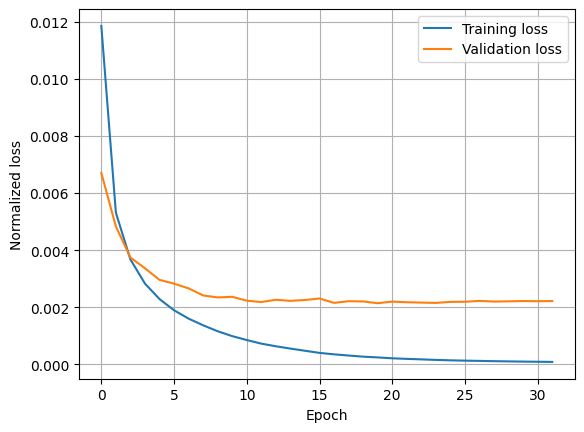

In [58]:
baseline_evaluation.plot_losses()

In [59]:
baseline_evaluation.test_model(test_loader)

Test accuracy:                  98.08000%
Test loss:                       0.00111%
Min Precision:                    0.9752 (Class: 9)
Median Precision:                 0.9789 (Class: 3)
Max Precision:                    0.9886 (Class: 1)


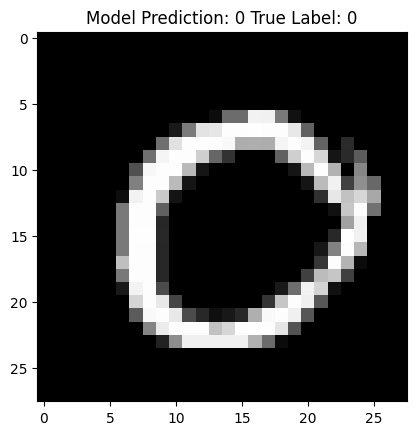

In [60]:
baseline_evaluation.get_example_prediction(baseline_model, test_loader)

In [61]:
best_model = baseline_evaluation.select_best_model(BasicMLP, basic_model_params)
print(best_model)

/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 1, Min Precision: 0.9029, Median Precision: 0.9297, Max Precision: 0.9710
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 2, Min Precision: 0.9305, Median Precision: 0.9519, Max Precision: 0.9853
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 3, Min Precision: 0.9425, Median Precision: 0.9644, Max Precision: 0.9756
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 4, Min Precision: 0.9483, Median Precision: 0.9694, Max Precision: 0.9876
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 5, Min Precision: 0.9555, Median Precision: 0.9728, Max Precision: 0.9902
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 6, Min Precision: 0.9367, Median Precision: 0.9738, Max Precision: 0.9899
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 7, Min Precision: 0.9431, Median Precision: 0.9776, Max Precision: 0.9899
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 8, Min Precision: 0.9593, Median Precision: 0.9746, Max Precision: 0.9903
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 9, Min Precision: 0.9631, Median Precision: 0.9775, Max Precision: 0.9878
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 10, Min Precision: 0.9549, Median Precision: 0.9774, Max Precision: 0.9855
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 11, Min Precision: 0.9556, Median Precision: 0.9777, Max Precision: 0.9855
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 12, Min Precision: 0.9581, Median Precision: 0.9782, Max Precision: 0.9877
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 13, Min Precision: 0.9649, Median Precision: 0.9749, Max Precision: 0.9932
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 14, Min Precision: 0.9558, Median Precision: 0.9808, Max Precision: 0.9877
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 15, Min Precision: 0.9669, Median Precision: 0.9786, Max Precision: 0.9894
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 16, Min Precision: 0.9639, Median Precision: 0.9788, Max Precision: 0.9910
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 17, Min Precision: 0.9724, Median Precision: 0.9783, Max Precision: 0.9847
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 18, Min Precision: 0.9571, Median Precision: 0.9803, Max Precision: 0.9878
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 19, Min Precision: 0.9691, Median Precision: 0.9795, Max Precision: 0.9882
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 20, Min Precision: 0.9704, Median Precision: 0.9794, Max Precision: 0.9846
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 21, Min Precision: 0.9654, Median Precision: 0.9787, Max Precision: 0.9866
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 22, Min Precision: 0.9634, Median Precision: 0.9793, Max Precision: 0.9856
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 23, Min Precision: 0.9719, Median Precision: 0.9776, Max Precision: 0.9875
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 24, Min Precision: 0.9657, Median Precision: 0.9808, Max Precision: 0.9875
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 25, Min Precision: 0.9708, Median Precision: 0.9782, Max Precision: 0.9932
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 26, Min Precision: 0.9678, Median Precision: 0.9798, Max Precision: 0.9846
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 27, Min Precision: 0.9679, Median Precision: 0.9779, Max Precision: 0.9858
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 28, Min Precision: 0.9700, Median Precision: 0.9778, Max Precision: 0.9913
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 29, Min Precision: 0.9741, Median Precision: 0.9794, Max Precision: 0.9903
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 30, Min Precision: 0.9679, Median Precision: 0.9779, Max Precision: 0.9844
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 31, Min Precision: 0.9709, Median Precision: 0.9784, Max Precision: 0.9894
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 32, Min Precision: 0.9679, Median Precision: 0.9798, Max Precision: 0.9856
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Best model is from epoch 28 with Min Precision: 0.9741
BasicMLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [62]:
baseline_evaluation.test_model(test_loader, best_model)

Test accuracy:                  98.11000%
Test loss:                       0.00108%
Min Precision:                    0.9756 (Class: 4)
Median Precision:                 0.9794 (Class: 3)
Max Precision:                    0.9929 (Class: 1)


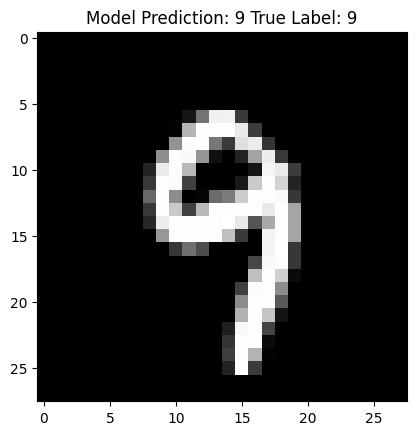

In [63]:
baseline_evaluation.get_example_prediction(best_model, test_loader)

## 9.b
Change the model so that there are two hidden layers.

In [64]:
class TwoLayerMLP(torch.nn.Module):
    def __init__(self, layer_one_num_outputs:int|np.int64, layer_two_num_outputs:int|np.int64):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(28*28, layer_one_num_outputs),
            torch.nn.ReLU(),
            torch.nn.Linear(layer_one_num_outputs, layer_two_num_outputs),
            torch.nn.ReLU(),
            torch.nn.Linear(layer_two_num_outputs, 10)
        )
    def forward(self, x:torch.Tensor):
        return self.layers(x)

In [65]:
n_epochs = 32
model_two_params = {"layer_one_num_outputs": 256, 
                    "layer_two_num_outputs": 128}
model_two = TwoLayerMLP(**model_two_params)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_two.parameters(), lr=0.01, momentum=0.9)
two_layer_evaluation = ModelEvaluator(train_loader, valid_loader, model_two, criterion, optimizer, n_epochs, "two_layer")
two_layer_evaluation.train(save_model_checkpoints=True)

--------------------------------------------------------------------------------
     Epoch Train Frac. Correct     Train Loss     Valid Loss
--------------------------------------------------------------------------------
         1             0.88024     0.01262749     0.00591768
         2             0.95673     0.00444926     0.00382508
         3             0.97233     0.00291419     0.00350167
         4             0.97906     0.00214223     0.00297530
         5             0.98347     0.00167544     0.00272979
         6             0.98722     0.00127075     0.00256612
         7             0.99041     0.00096817     0.00267936
         8             0.99304     0.00075584     0.00260662
         9             0.99508     0.00055309     0.00261631
        10             0.99635     0.00041562     0.00253319
        11             0.99751     0.00031684     0.00245696
        12             0.99851     0.00021772     0.00252721
        13             0.99875     0.00018198

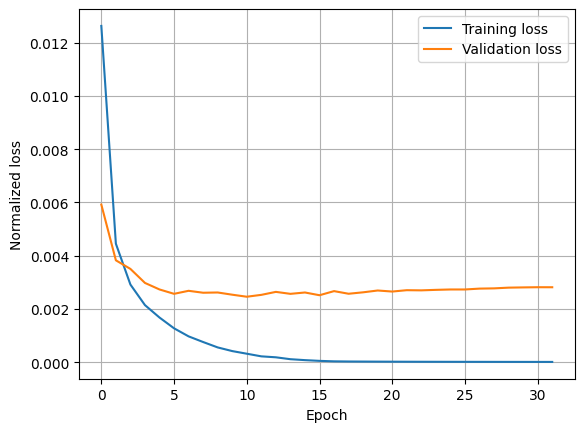

In [66]:
two_layer_evaluation.plot_losses()

In [67]:
two_layer_evaluation.test_model(test_loader)

Test accuracy:                  98.15000%
Test loss:                       0.00140%
Min Precision:                    0.9715 (Class: 9)
Median Precision:                 0.9823 (Class: 7)
Max Precision:                    0.9921 (Class: 1)


In [68]:
best_two_layer_model = two_layer_evaluation.select_best_model(TwoLayerMLP, model_two_params)
print(best_model)

/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 1, Min Precision: 0.9037, Median Precision: 0.9533, Max Precision: 0.9776
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 2, Min Precision: 0.9354, Median Precision: 0.9634, Max Precision: 0.9787
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 3, Min Precision: 0.9254, Median Precision: 0.9710, Max Precision: 0.9903
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 4, Min Precision: 0.9555, Median Precision: 0.9735, Max Precision: 0.9865
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 5, Min Precision: 0.9536, Median Precision: 0.9745, Max Precision: 0.9903
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 6, Min Precision: 0.9622, Median Precision: 0.9752, Max Precision: 0.9888
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 7, Min Precision: 0.9249, Median Precision: 0.9812, Max Precision: 0.9888
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 8, Min Precision: 0.9523, Median Precision: 0.9772, Max Precision: 0.9921
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 9, Min Precision: 0.9539, Median Precision: 0.9788, Max Precision: 0.9834
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 10, Min Precision: 0.9583, Median Precision: 0.9789, Max Precision: 0.9942
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 11, Min Precision: 0.9691, Median Precision: 0.9798, Max Precision: 0.9951
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 12, Min Precision: 0.9703, Median Precision: 0.9806, Max Precision: 0.9870
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 13, Min Precision: 0.9545, Median Precision: 0.9776, Max Precision: 0.9955
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 14, Min Precision: 0.9628, Median Precision: 0.9790, Max Precision: 0.9913
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 15, Min Precision: 0.9691, Median Precision: 0.9781, Max Precision: 0.9913
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 16, Min Precision: 0.9678, Median Precision: 0.9797, Max Precision: 0.9911
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 17, Min Precision: 0.9715, Median Precision: 0.9798, Max Precision: 0.9904
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 18, Min Precision: 0.9716, Median Precision: 0.9798, Max Precision: 0.9900
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 19, Min Precision: 0.9709, Median Precision: 0.9809, Max Precision: 0.9913
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 20, Min Precision: 0.9691, Median Precision: 0.9799, Max Precision: 0.9911
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 21, Min Precision: 0.9692, Median Precision: 0.9798, Max Precision: 0.9911
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 22, Min Precision: 0.9703, Median Precision: 0.9809, Max Precision: 0.9911
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 23, Min Precision: 0.9716, Median Precision: 0.9787, Max Precision: 0.9911
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 24, Min Precision: 0.9692, Median Precision: 0.9798, Max Precision: 0.9900
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 25, Min Precision: 0.9704, Median Precision: 0.9793, Max Precision: 0.9889
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 26, Min Precision: 0.9704, Median Precision: 0.9794, Max Precision: 0.9911
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 27, Min Precision: 0.9704, Median Precision: 0.9798, Max Precision: 0.9900
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 28, Min Precision: 0.9704, Median Precision: 0.9789, Max Precision: 0.9911
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 29, Min Precision: 0.9716, Median Precision: 0.9793, Max Precision: 0.9911
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 30, Min Precision: 0.9728, Median Precision: 0.9798, Max Precision: 0.9911
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 31, Min Precision: 0.9716, Median Precision: 0.9803, Max Precision: 0.9911
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 32, Min Precision: 0.9704, Median Precision: 0.9793, Max Precision: 0.9900
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Best model is from epoch 29 with Min Precision: 0.9728
BasicMLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [69]:
two_layer_evaluation.test_model(test_loader, best_two_layer_model)

Test accuracy:                  98.12000%
Test loss:                       0.00139%
Min Precision:                    0.9715 (Class: 9)
Median Precision:                 0.9818 (Class: 3)
Max Precision:                    0.9921 (Class: 1)


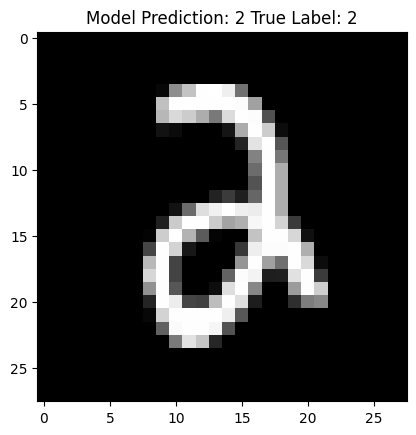

In [70]:
two_layer_evaluation.get_example_prediction(model_two, test_loader)

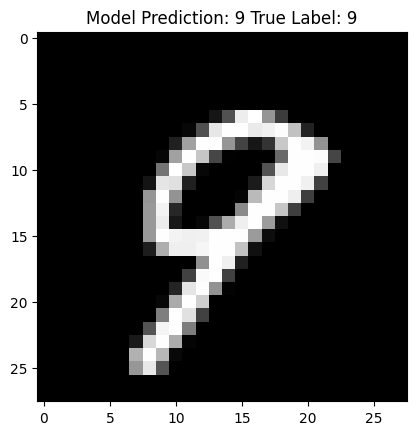

In [71]:
two_layer_evaluation.get_example_prediction(best_two_layer_model, test_loader)

Let's see if changing the optimizer does anything.

In [72]:
n_epochs = 32
baseline_adam_model = BasicMLP(basic_model_params["num_outputs"])
criterion = torch.nn.CrossEntropyLoss()
adam_opt = torch.optim.Adam(baseline_adam_model.parameters(), lr=1e-3) #torch.optim.SGD(baseline_model.parameters(), lr=0.01, momentum=0.9)
baseline_adam_evaluation = ModelEvaluator(train_loader, valid_loader, baseline_adam_model, criterion, adam_opt, n_epochs, "baseline_adam")
baseline_adam_evaluation.train(save_model_checkpoints=True)

--------------------------------------------------------------------------------
     Epoch Train Frac. Correct     Train Loss     Valid Loss
--------------------------------------------------------------------------------
         1             0.92188     0.00846688     0.00450065
         2             0.96645     0.00351053     0.00313969
         3             0.97804     0.00227756     0.00287955
         4             0.98353     0.00164167     0.00258964
         5             0.98792     0.00123169     0.00255423
         6             0.99082     0.00089515     0.00247862
         7             0.99314     0.00072895     0.00247809
         8             0.99504     0.00052061     0.00274401
         9             0.99482     0.00049128     0.00272263
        10             0.99676     0.00034870     0.00250814
        11             0.99686     0.00030248     0.00274298
        12             0.99673     0.00031757     0.00287838
        13             0.99700     0.00026958

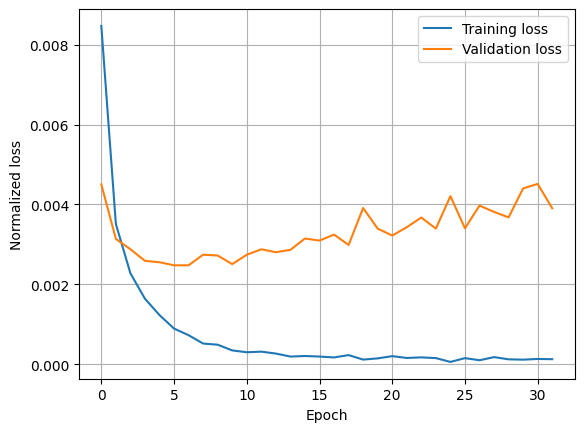

In [73]:
baseline_adam_evaluation.plot_losses()

In [74]:
baseline_adam_evaluation.test_model(test_loader)

Test accuracy:                  97.85000%
Test loss:                       0.00232%
Min Precision:                    0.9612 (Class: 8)
Median Precision:                 0.9817 (Class: 1)
Max Precision:                    0.9891 (Class: 2)


In [75]:
best_adam_model = baseline_adam_evaluation.select_best_model(BasicMLP, basic_model_params)

/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 1, Min Precision: 0.9379, Median Precision: 0.9501, Max Precision: 0.9821
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 2, Min Precision: 0.9418, Median Precision: 0.9712, Max Precision: 0.9865
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 3, Min Precision: 0.9439, Median Precision: 0.9750, Max Precision: 0.9910
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 4, Min Precision: 0.9616, Median Precision: 0.9746, Max Precision: 0.9904
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 5, Min Precision: 0.9516, Median Precision: 0.9765, Max Precision: 0.9933
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 6, Min Precision: 0.9529, Median Precision: 0.9788, Max Precision: 0.9932
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 7, Min Precision: 0.9579, Median Precision: 0.9805, Max Precision: 0.9922
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 8, Min Precision: 0.9592, Median Precision: 0.9779, Max Precision: 0.9870
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 9, Min Precision: 0.9560, Median Precision: 0.9781, Max Precision: 0.9910
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 10, Min Precision: 0.9654, Median Precision: 0.9793, Max Precision: 0.9885
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 11, Min Precision: 0.9615, Median Precision: 0.9776, Max Precision: 0.9954
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 12, Min Precision: 0.9428, Median Precision: 0.9811, Max Precision: 0.9900
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 13, Min Precision: 0.9677, Median Precision: 0.9776, Max Precision: 0.9921
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 14, Min Precision: 0.9530, Median Precision: 0.9829, Max Precision: 0.9911
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 15, Min Precision: 0.9636, Median Precision: 0.9798, Max Precision: 0.9955
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 16, Min Precision: 0.9597, Median Precision: 0.9776, Max Precision: 0.9941
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 17, Min Precision: 0.9617, Median Precision: 0.9794, Max Precision: 0.9922
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 18, Min Precision: 0.9645, Median Precision: 0.9821, Max Precision: 0.9900
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 19, Min Precision: 0.9580, Median Precision: 0.9765, Max Precision: 0.9910
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 20, Min Precision: 0.9645, Median Precision: 0.9792, Max Precision: 0.9913
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 21, Min Precision: 0.9622, Median Precision: 0.9789, Max Precision: 0.9933
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 22, Min Precision: 0.9569, Median Precision: 0.9815, Max Precision: 0.9878
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 23, Min Precision: 0.9521, Median Precision: 0.9831, Max Precision: 0.9933
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 24, Min Precision: 0.9705, Median Precision: 0.9786, Max Precision: 0.9933
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 25, Min Precision: 0.9498, Median Precision: 0.9814, Max Precision: 0.9904
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 26, Min Precision: 0.9670, Median Precision: 0.9790, Max Precision: 0.9913
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 27, Min Precision: 0.9489, Median Precision: 0.9775, Max Precision: 0.9918
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 28, Min Precision: 0.9606, Median Precision: 0.9786, Max Precision: 0.9894
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 29, Min Precision: 0.9728, Median Precision: 0.9790, Max Precision: 0.9875
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 30, Min Precision: 0.9666, Median Precision: 0.9780, Max Precision: 0.9885
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 31, Min Precision: 0.9642, Median Precision: 0.9764, Max Precision: 0.9944
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 32, Min Precision: 0.9690, Median Precision: 0.9779, Max Precision: 0.9895
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Best model is from epoch 28 with Min Precision: 0.9728


In [76]:
baseline_adam_evaluation.test_model(test_loader, best_adam_model)

Test accuracy:                  97.87000%
Test loss:                       0.00205%
Min Precision:                    0.9724 (Class: 9)
Median Precision:                 0.9784 (Class: 7)
Max Precision:                    0.9868 (Class: 1)


In [77]:
# two layers and adam

n_epochs = 32
model_two_params = {"layer_one_num_outputs": 256, 
                    "layer_two_num_outputs": 128}
adam_model_two = TwoLayerMLP(**model_two_params)
criterion = torch.nn.CrossEntropyLoss()
adam_two_layer_optimizer = torch.optim.Adam(adam_model_two.parameters(), lr=1e-3) #torch.optim.SGD(model_two.parameters(), lr=0.01, momentum=0.9)
adam_two_layer_evaluation = ModelEvaluator(train_loader, valid_loader, adam_model_two, criterion, adam_two_layer_optimizer, n_epochs, "two_layer_adam")
adam_two_layer_evaluation.train(save_model_checkpoints=True)

--------------------------------------------------------------------------------
     Epoch Train Frac. Correct     Train Loss     Valid Loss
--------------------------------------------------------------------------------
         1             0.92282     0.00821252     0.00428303
         2             0.96727     0.00328884     0.00325923
         3             0.97837     0.00213989     0.00289376
         4             0.98449     0.00153351     0.00317822
         5             0.98716     0.00120951     0.00287381
         6             0.98935     0.00101273     0.00245717
         7             0.99143     0.00080097     0.00303791
         8             0.99294     0.00065967     0.00269592
         9             0.99365     0.00057378     0.00286455
        10             0.99435     0.00054117     0.00330791
        11             0.99425     0.00056815     0.00324093
        12             0.99559     0.00040088     0.00326619
        13             0.99573     0.00040990

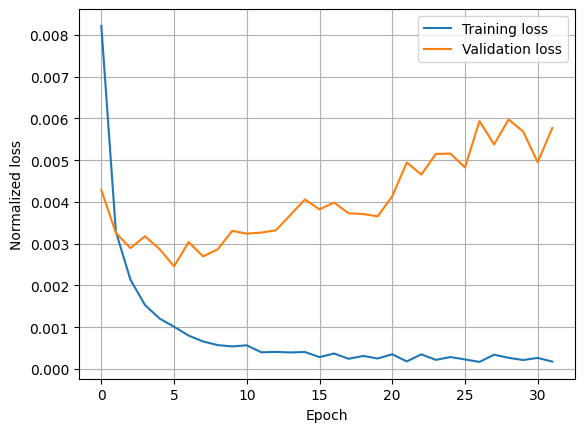

In [78]:
adam_two_layer_evaluation.plot_losses()

In [79]:
adam_two_layer_evaluation.test_model(test_loader)

Test accuracy:                  97.88000%
Test loss:                       0.00279%
Min Precision:                    0.9618 (Class: 8)
Median Precision:                 0.9797 (Class: 7)
Max Precision:                    0.9930 (Class: 1)


In [80]:
best_adam_two_layer_model = adam_two_layer_evaluation.select_best_model(TwoLayerMLP, model_two_params)

/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 1, Min Precision: 0.9091, Median Precision: 0.9654, Max Precision: 0.9854
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 2, Min Precision: 0.9197, Median Precision: 0.9713, Max Precision: 0.9875
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 3, Min Precision: 0.9446, Median Precision: 0.9752, Max Precision: 0.9877
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 4, Min Precision: 0.9109, Median Precision: 0.9692, Max Precision: 0.9943
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 5, Min Precision: 0.9566, Median Precision: 0.9726, Max Precision: 0.9944
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 6, Min Precision: 0.9642, Median Precision: 0.9751, Max Precision: 0.9921
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 7, Min Precision: 0.9309, Median Precision: 0.9797, Max Precision: 0.9856
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 8, Min Precision: 0.9578, Median Precision: 0.9719, Max Precision: 0.9942
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 9, Min Precision: 0.9558, Median Precision: 0.9832, Max Precision: 0.9911
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 10, Min Precision: 0.9483, Median Precision: 0.9778, Max Precision: 0.9923
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 11, Min Precision: 0.9568, Median Precision: 0.9790, Max Precision: 0.9856
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 12, Min Precision: 0.9572, Median Precision: 0.9755, Max Precision: 0.9906
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 13, Min Precision: 0.9516, Median Precision: 0.9803, Max Precision: 0.9885
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 14, Min Precision: 0.9676, Median Precision: 0.9715, Max Precision: 0.9911
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 15, Min Precision: 0.9387, Median Precision: 0.9808, Max Precision: 0.9878
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 16, Min Precision: 0.9454, Median Precision: 0.9775, Max Precision: 0.9944
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 17, Min Precision: 0.9587, Median Precision: 0.9825, Max Precision: 0.9955
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 18, Min Precision: 0.9580, Median Precision: 0.9798, Max Precision: 0.9911
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 19, Min Precision: 0.9570, Median Precision: 0.9781, Max Precision: 0.9885
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 20, Min Precision: 0.9627, Median Precision: 0.9791, Max Precision: 0.9923
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 21, Min Precision: 0.9587, Median Precision: 0.9792, Max Precision: 0.9932
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 22, Min Precision: 0.9515, Median Precision: 0.9769, Max Precision: 0.9917
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 23, Min Precision: 0.9495, Median Precision: 0.9778, Max Precision: 0.9966
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 24, Min Precision: 0.9507, Median Precision: 0.9797, Max Precision: 0.9911
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 25, Min Precision: 0.9525, Median Precision: 0.9782, Max Precision: 0.9911
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 26, Min Precision: 0.9544, Median Precision: 0.9794, Max Precision: 0.9894
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 27, Min Precision: 0.9438, Median Precision: 0.9747, Max Precision: 0.9894
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 28, Min Precision: 0.9597, Median Precision: 0.9813, Max Precision: 0.9922
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 29, Min Precision: 0.9557, Median Precision: 0.9739, Max Precision: 0.9922
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 30, Min Precision: 0.9242, Median Precision: 0.9837, Max Precision: 0.9961
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 31, Min Precision: 0.9587, Median Precision: 0.9813, Max Precision: 0.9944
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


/var/folders/ts/39plpy691lg3xd9rvzndrmt40000gq/T/ipykernel_24507/1601083874.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_model.load_state_dict(torch.load(

Epoch: 32, Min Precision: 0.9551, Median Precision: 0.9779, Max Precision: 0.9906
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Best model is from epoch 13 with Min Precision: 0.9676


In [81]:
adam_two_layer_evaluation.test_model(test_loader, best_adam_two_layer_model)

Test accuracy:                  97.55000%
Test loss:                       0.00200%
Min Precision:                    0.9517 (Class: 8)
Median Precision:                 0.9756 (Class: 9)
Max Precision:                    0.9947 (Class: 1)


### Extensions:
- Use more layers
- Use different hyperparameters
- Use different activations